<a href="https://colab.research.google.com/github/cgbas/tc-data-analytics/blob/feature%2Ffase2/fase%202/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo preditivo Ibovespa

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados do IBOVESPA (Bolsa de Valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso utilize a base  de dados contida no [Site da Investing](!https://br.investing.com/indices/bovespa-historical-data) e selecione o período diário, com o intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

- O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
- Justificar a técnica utilizada;
- Atingir uma acuracidade adequada (acima de 70%)

_Dica: utilize o maior intervalo de tempo possível para atingir maior acuracidade no modelo preditivo._

### Coleta e Tratamento dos dados

Consideraremos dados desde o primeiro dia do plano real (01/07/1994) em nossa análise preliminar, inclusive para entender a ocorrência de outliers desde a introdução de nossa moeda corrente.



In [27]:
#bibliotecas que vamos usar neste estudo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller

In [28]:
df_ibovespa = pd.read_csv('/content/DadosHistoricosIbovespa_de_1995_ate_2024.csv', dtype=str, dayfirst=True, parse_dates=[0], index_col='Data') #importando os dados, importamos tudo como string para evitar perder os 0 (a esquerda e direita) dos números. E também já convertendo a coluna "Data" para o tipo datetime. Deixa a coluna data como o índice da tabela.
df_ibovespa.head() #verificando os dados

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2010-06-30,60.936,61.972,62.645,60.936,"1,96M","-1,68%"
2010-06-29,61.978,64.216,64.216,61.670,"2,20M","-3,50%"
2010-06-28,64.225,64.825,65.105,64.225,"943,30K","-0,92%"
2010-06-25,64.824,63.937,64.869,63.806,"1,26M","1,39%"
2010-06-24,63.937,65.154,65.154,63.736,"1,79M","-1,88%"


In [29]:
#Excluindo a coluna que não vamos usar para a análise
df_ibovespa.drop(columns=['Var%'], inplace=True)

#Renomeando as colunas restantes, para não termos problemas com funções futuras (pois tem acentos)
df_ibovespa.columns = ['Fechamento', 'Abertura', 'Maxima', 'Minima', 'VolumeNegociado']
df_ibovespa.head() #verificando sucesso das alterações

,Fechamento,Abertura,Maxima,Minima,VolumeNegociado
Data,,,,,
2010-06-30,60.936,61.972,62.645,60.936,"1,96M"
2010-06-29,61.978,64.216,64.216,61.670,"2,20M"
2010-06-28,64.225,64.825,65.105,64.225,"943,30K"
2010-06-25,64.824,63.937,64.869,63.806,"1,26M"
2010-06-24,63.937,65.154,65.154,63.736,"1,79M"


In [30]:
#Alterando os tipos dos dados
df_ibovespa['Fechamento'] = df_ibovespa['Fechamento'].str.replace('.', '').astype(int) # Convertendo a coluna para o tipo inteiro
df_ibovespa['Abertura'] = df_ibovespa['Abertura'].str.replace('.', '').astype(int) # Convertendo a coluna para o tipo inteiro
df_ibovespa['Maxima'] = df_ibovespa['Maxima'].str.replace('.', '').astype(int) # Convertendo a coluna para o tipo inteiro
df_ibovespa['Minima'] = df_ibovespa['Minima'].str.replace('.', '').astype(int) # Convertendo a coluna para o tipo inteiro
df_ibovespa['VolumeNegociado'] = df_ibovespa['VolumeNegociado'].str[:-1].str.replace(',', '.').astype(float) * df_ibovespa['VolumeNegociado'].str[-1:].map({'K':1000, 'M':1000000, 'B':1000000000}) #Convertendo de texto para número
df_ibovespa.head() #verificando o resultado

,Fechamento,Abertura,Maxima,Minima,VolumeNegociado
Data,,,,,
2010-06-30,60936,61972,62645,60936,1960000.0
2010-06-29,61978,64216,64216,61670,2200000.0
2010-06-28,64225,64825,65105,64225,943300.0
2010-06-25,64824,63937,64869,63806,1260000.0
2010-06-24,63937,65154,65154,63736,1790000.0


# Análise exploratória

In [31]:
#Verificando a quantidade de linhas que temos para a análise (linhas, colunas)
df_ibovespa.shape

(7439, 5)

In [32]:
#estatísticas básicas do nosso dataframe
df_ibovespa.describe()

,Fechamento,Abertura,Maxima,Minima,VolumeNegociado
count,7439.000000,7439.000000,7439.000000,7439.000000,7.438000e+03
mean,50111.120177,50095.360532,50600.950262,49595.968813,1.597423e+09
std,36327.662752,36319.405200,36602.815645,36038.073257,3.909850e+09
min,2138.000000,2138.000000,2449.000000,2110.000000,1.121000e+05
25%,14047.500000,14048.000000,14219.500000,13854.500000,3.560000e+06
50%,50518.000000,50511.000000,51171.000000,50005.000000,1.150000e+07
75%,68618.500000,68607.500000,69304.500000,68026.500000,2.760725e+08
max,134194.000000,134194.000000,134392.000000,133832.000000,5.406000e+10


In [33]:
#verificando quantidade de dados nulos
df_ibovespa.isnull().sum()

Fechamento         0
Abertura           0
Maxima             0
Minima             0
VolumeNegociado    1
dtype: int64

<Axes: >

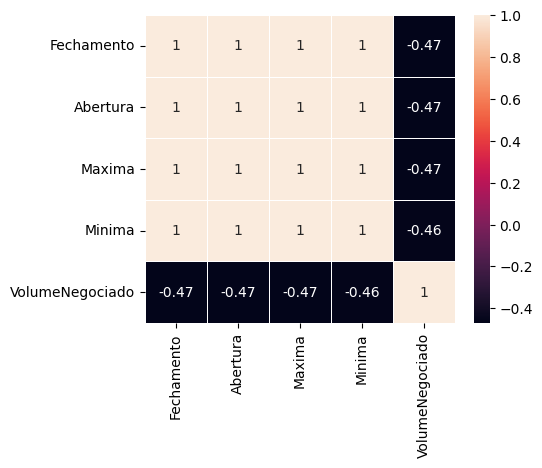

In [34]:
#Criando um gráfico de correlação para entendermos se as colunas tem algum tipo de correlação
dados_correlacao = df_ibovespa.select_dtypes(include=['int64', 'float64']) #Selecionando apenas as colunas que tem números
correlation_matrix = dados_correlacao.corr().round(2) #Criando a matriz de correlação
fig, ax = plt.subplots(figsize=(5, 4)) #indica o tamanho do gráfico
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax) #criando o gráfico de correlação

#Visualizando valores de fechamento

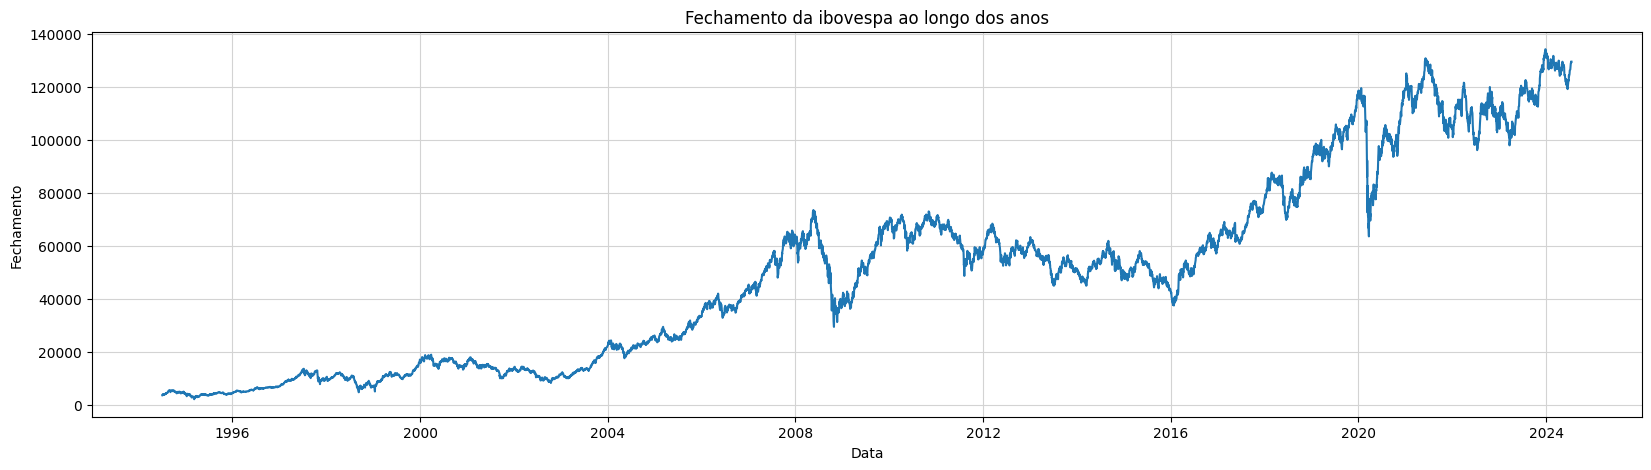

In [35]:
#Vamos analisar a variação do valor de fechamento ao longo dos anos
#Criando o gráfico de linhas para analisar se temos grandes mudanças ao longo do tempo na média de segundos ativos no checkout
fig, ax = plt.subplots(figsize=(20, 5)) #indica o tamanho do gráfico
ax.grid(True, color='lightgray') #Coloca as linhas de grade
sns.lineplot(x='Data', y='Fechamento', data=df_ibovespa) #cria o gráfico de linhas
ax.set_title('Fechamento da ibovespa ao longo dos anos') #título do gráfico
plt.show() #mostrando o gráfico

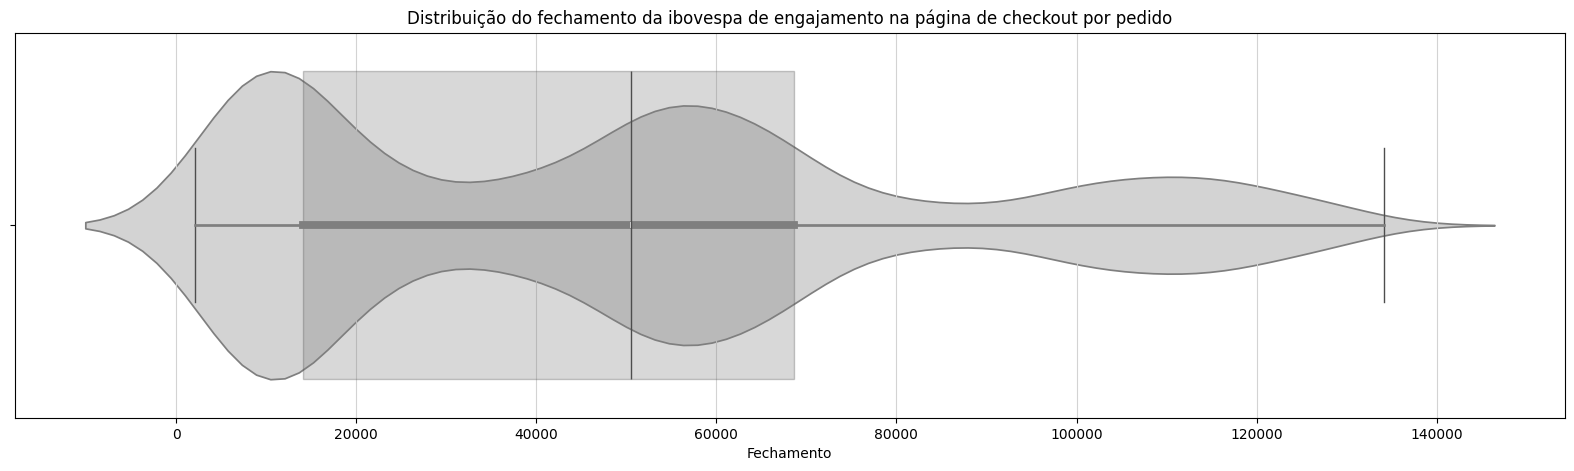

In [36]:
#Vamos analisar a distribuição desses dados com o violinplot, mesclado com o boxplot
fig, ax = plt.subplots(figsize=(20,5)) #indica o tamanho do gráfico
ax.grid(True, color='lightgray') #Coloca as linhas de grade
sns.boxplot(data=df_ibovespa, x='Fechamento', color='gray', boxprops=dict(alpha=.3)) #criando o boxplot
sns.violinplot(data=df_ibovespa, x='Fechamento', color='lightgray') #criando o violinplot
ax.set_title("Distribuição do fechamento da ibovespa de engajamento na página de checkout por pedido") #Título do gráfico
plt.show() #mostrando o gráfico

Como podemos ver, nossos dados são muito distantes entre si, por conta do grande período da nossa série temporal. Vamos fazer uma decomposição desses dados. Para que possamos analisar:
- Tendencia
- Sazonalidade
- Ruído

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [38]:
df_ibovespa_limpo = df_ibovespa.copy() #cópia do dataframe
df_ibovespa_limpo = df_ibovespa_limpo[['Fechamento']] #Pegando apenas colunas que vamos usar
df_ibovespa_limpo #verificando sucesso

,Fechamento
Data,
2010-06-30,60936
2010-06-29,61978
2010-06-28,64225
2010-06-25,64824
2010-06-24,63937
...,...
2010-07-07,63284
2010-07-06,62065
2010-07-05,60865


In [39]:
resultados = seasonal_decompose(df_ibovespa_limpo, model='multiplicative', period=5) #escolhida decomposição de 5 períodos pois foram uma semana (seg a sex).

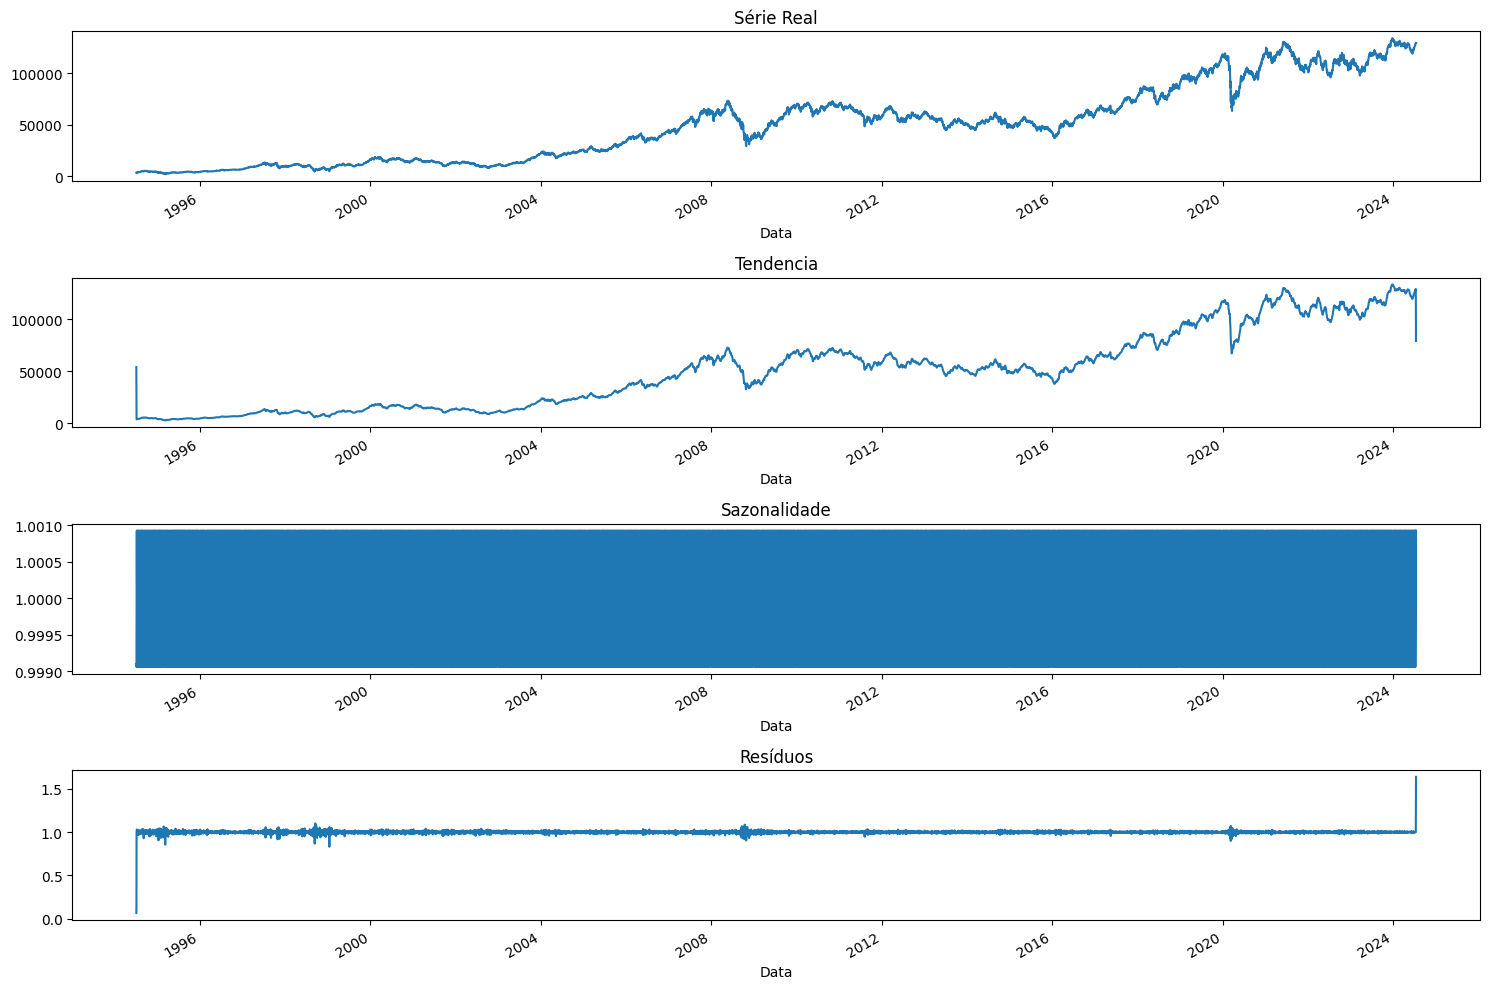

In [40]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10)) #cria as 4 figuras para plotarmos os gráficos
resultados.observed.plot(ax=ax1) #serie real
ax1.set_title('Série Real') #título do eixo 1
resultados.trend.plot(ax=ax2) #tendencia
ax2.set_title('Tendencia') #título do eixo 2
resultados.seasonal.plot(ax=ax3) #sazonalidade
ax3.set_title('Sazonalidade') #título do eixo 3
resultados.resid.plot(ax=ax4) #residuos
ax4.set_title('Resíduos') #título do eixo 4

plt.tight_layout() #Ajusta o padding entre os gráficos
plt.show() #mostrando os gráficos

Como podemos ver nos dados acima, os dados de fechamento da b3 tem uma ampla sazonalidade, o que dificulta a previsão de valores.

Também, a tendência do valor de fechamento fica bem voltada para cima, pois estamos comparando um período muito distante e com um valor de fechamento bem abaixo do que é realizado hoje em dia.

A partir do ano de 2021 nossos dados começam a ficar mais próximos da realidade que é hoje, antes disso tínhamos a pandemia da COVID-19 que fez com que os números de fechamento ficassem muito incertos, e ainda antes da pandemia nossos números eram baixos principalmente por conta da inflação e também por que tínhamos bem menos volume sendo negociado diariamente na bolsa de valores, confirmamos isso no gráfico abaixo:

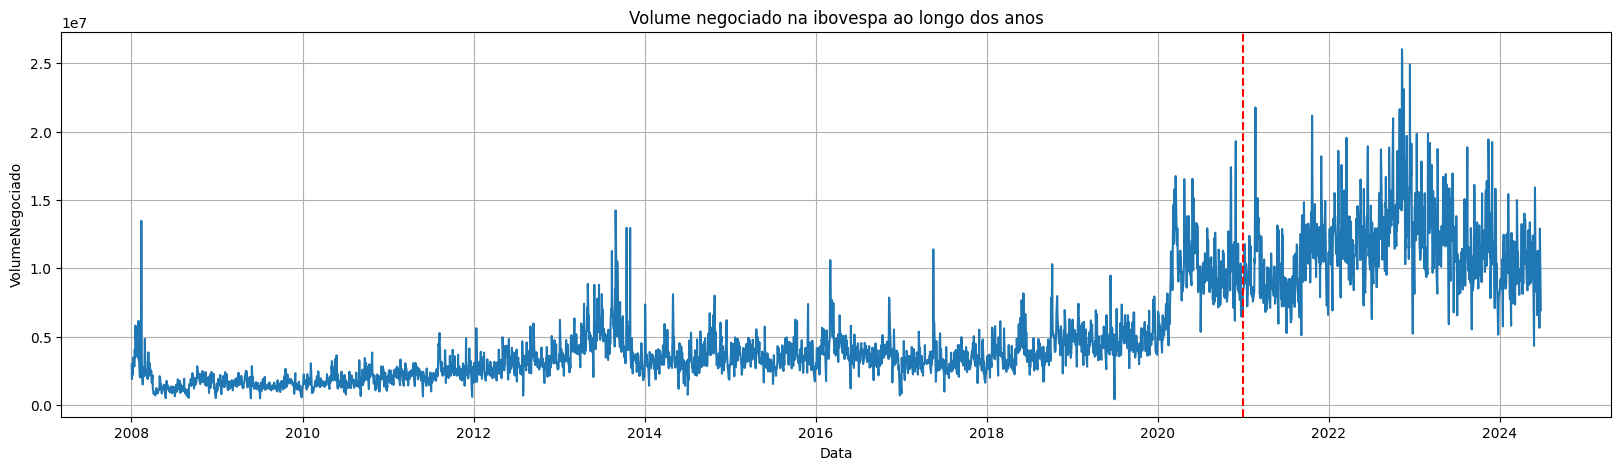

In [41]:
#Criando o gráfico de linhas para analisar os valores negociados na ibovespa
fig, ax = plt.subplots(figsize=(20, 5)) #indica o tamanho do gráfico
ax.grid(True) #Coloca as linhas de grade
sns.lineplot(data=df_ibovespa.loc['2008-01-02':'2024-06-25'], x='Data', y='VolumeNegociado') #cria o gráfico de linhas
ax.set_title('Volume negociado na ibovespa ao longo dos anos') #título do gráfico
ax.axvline(pd.Timestamp('2021-01-01'), color='red', linestyle='--') #adicionando uma linha vermelha a partir de 2021
plt.show() #mostrando o gráfico

Assim sendo resolvemos que o período a partir do dia 01/01/2021 será o ideal para nossas análises, pois é justamente o "início do fim" da pandemia, onde o mercado começou a ficar mais estável.

In [42]:
#Filtrando nossos dados para que sejam a partir da data 04/01/2021 (o primeiro dia de 2021 da nossa base)
df_ibovespa = df_ibovespa['2021-01-04':]

Agora vamos fazer a decomposição dos dados novamente

In [43]:
df_ibovespa_limpo = df_ibovespa.copy() #cópia do dataframe
df_ibovespa_limpo = df_ibovespa_limpo[['Fechamento']] #Pegando apenas colunas que vamos usar

In [44]:
resultados = seasonal_decompose(df_ibovespa_limpo, model='multiplicative', period=2) #dessa vez escolhemos fazer a decomposição a cada 2 períodos (anteriormente fizemos com 5)

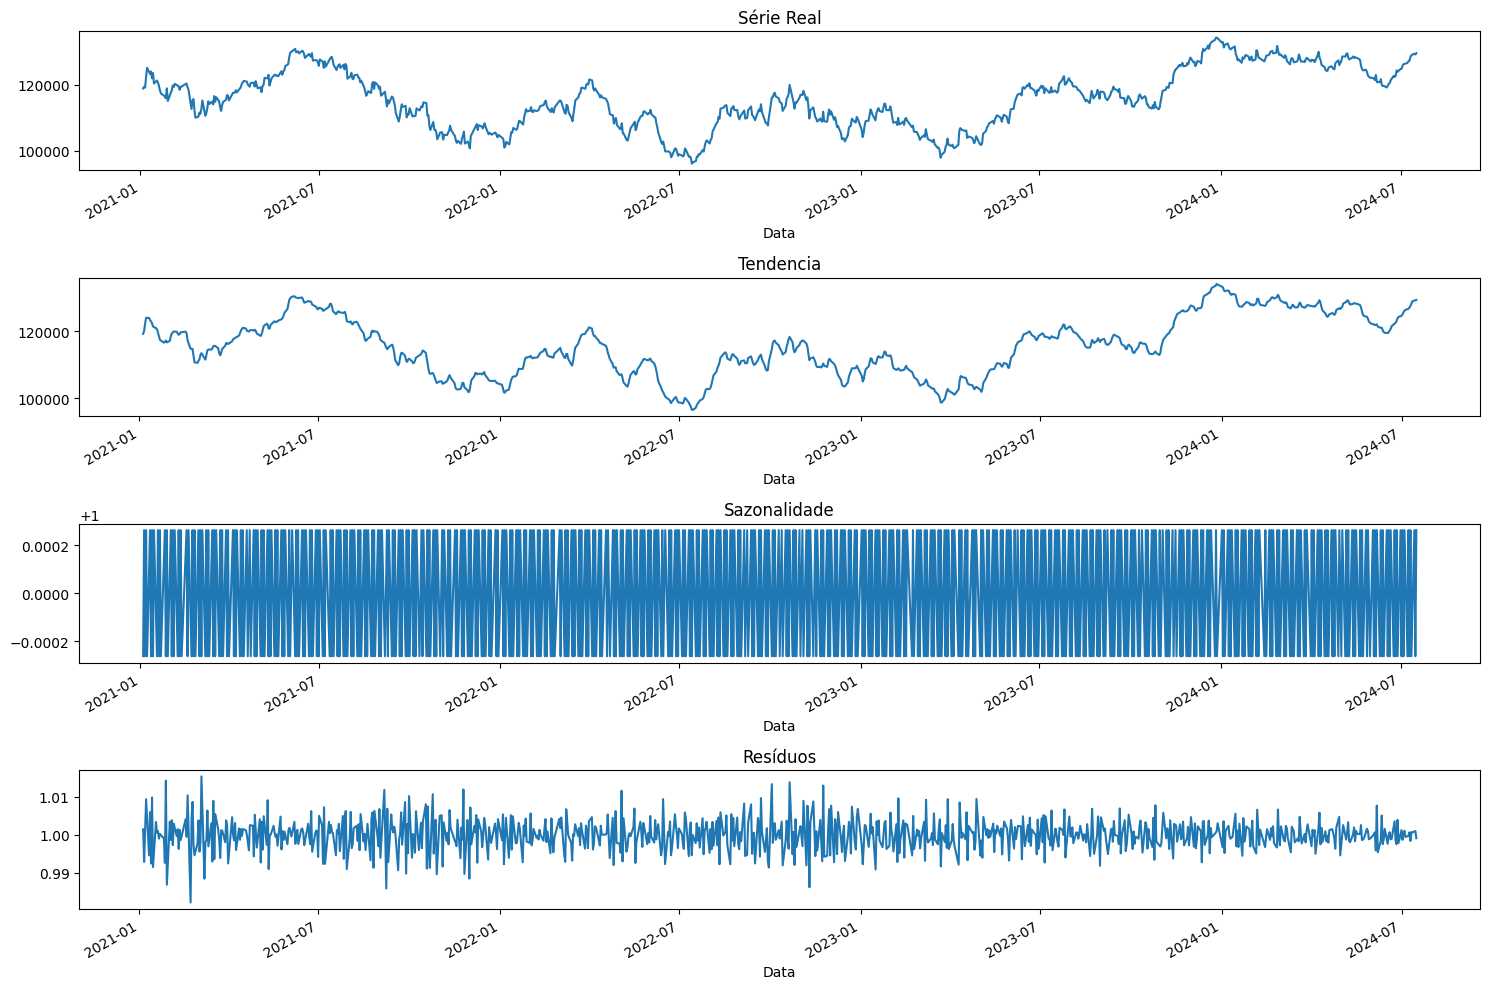

In [45]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10)) #cria as 4 figuras para plotarmos os gráficos
resultados.observed.plot(ax=ax1) #serie real
ax1.set_title('Série Real') #título do eixo 1
resultados.trend.plot(ax=ax2) #tendencia
ax2.set_title('Tendencia') #título do eixo 2
resultados.seasonal.plot(ax=ax3) #sazonalidade
ax3.set_title('Sazonalidade') #título do eixo 3
resultados.resid.plot(ax=ax4) #residuos
ax4.set_title('Resíduos') #título do eixo 4

plt.tight_layout() #Ajusta o padding entre os gráficos
plt.show() #mostrando os gráficos

Como esperado, vemos uma melhor concentração nos dados agora. Nossa tendencia é mais consistente e a sazonalidade é menor.

# Previsão dos valores de fechamento usando a regressão *linear*

#Previsão dos valores de fechamento usando o modelo ARIMA

Primeiramente vamos analisar a correlação dos dados.

In [46]:
import statsmodels.api as sm

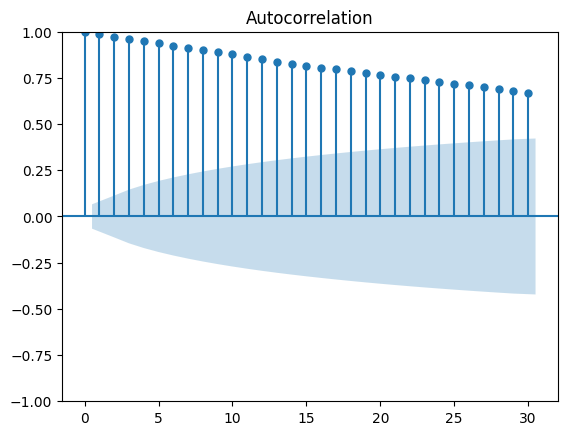

In [47]:
sm.graphics.tsa.plot_acf(df_ibovespa_limpo, lags=30) #cria o gráfico de autocorrelação com 30 lags
plt.show() #Para mostrar o gráfico de autocorrelação

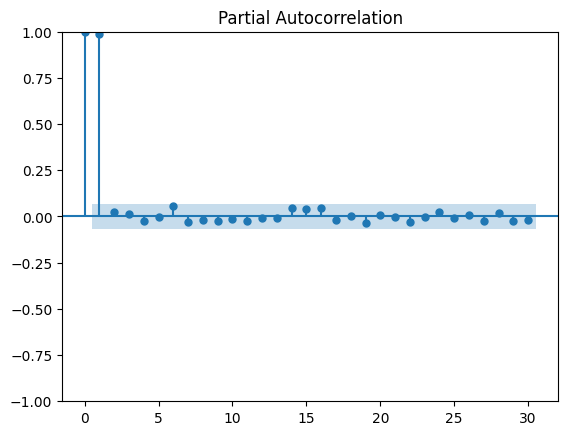

In [54]:
sm.graphics.tsa.plot_pacf(df_ibovespa_limpo, lags=30) #cria o gráfico de autocorrelação parcial com 30 lags
plt.show() #Para mostrar o gráfico de autocorrelação

Agora precisamos validar se nossa série de dados é estacionária. Já vimos que ela ficou mais concentrada, mas precisamos de estatística para termos certeza se ela é estacionária ou não.

*Estacionária ou não estacionária? Vamos fazer o teste de ADF (Augmented Dickey-Fuller)*

H0 - Hipótese nula (A série temporal NÃO é estacionária)

H1 - Hipótese alternativa (A série temporal é estacionária)

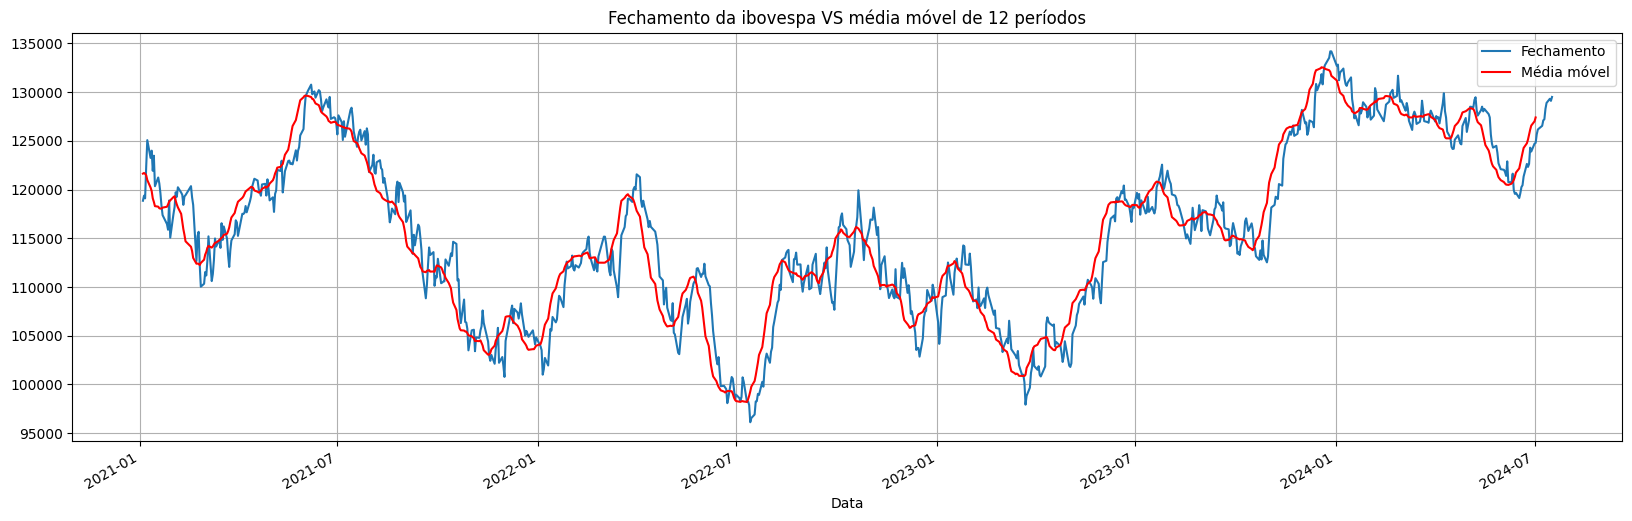

In [76]:
ma = df_ibovespa_limpo.rolling(12).mean() #pega uma média móvel a cada 12 períodos
f, ax = plt.subplots(figsize=(20, 6)) #indica o tamanho do gráfico
df_ibovespa_limpo.plot(ax=ax, y='Fechamento', label='Fechamento') #cria o gráfico de linhas do fechamento
ma.plot(ax=ax, y='Fechamento', color="red", label='Média móvel') #cria o gráfico de linhas da média móvel
plt.grid(True) #coloca grade no gráfico
plt.legend() #mostra a legenda
plt.title('Fechamento da ibovespa VS média móvel de 12 períodos') #adicionando um título ao gráfico
plt.show() #mostrando os gráficos

In [57]:
X = df_ibovespa_limpo.Fechamento.values #pega apenas os números do fechamento
result = adfuller(X) #Atribui a função de adfuller a variavel result

print(f'ADF Statistic: {result[0]}') #printa o resultado de adf
print(f'p-value: {result[1]}') #printa o p-value

print(f'Valores críticos:') #printa os valores críticos
for key, value in result[4].items():
    print(f'{key}: {value}')

#Indica se a série é temporal ou não com base no resultado do p-value.
if result[1] <= 0.05:
    print("A série temporal é estacionária.")
else:
    print("A série temporal não é estacionária.")

ADF Statistic: -2.5707537835471928
p-value: 0.0991937636078401
Valores críticos:
1%: -3.4377943310889303
5%: -2.8648262173548456
10%: -2.5685198165973295
A série temporal não é estacionária.


Com um teste de 5% de confiança, podemos dizer portanto que nossa série NÃO é estacionária.

Mas para fazermos o ARIMA, precisamos de uma série estacionária, portanto teremos que converter essa série para estacionária.

In [47]:
#Vamos usar logaritmo para fazer a conversão!
df_ibovespa_limpo_log = np.log(df_ibovespa_limpo)